### TP-4: CBOW Model for Word Embeddings 
 
Introduction

The Continuous Bag of Words (CBOW) model is a neural network-based approach for 
learning word embeddings. In CBOW, the context words are used to predict the target 
word. This exercise allows you to train a CBOW model on a given text corpus (any 
dataset) and learn embeddings for each word in the vocabulary. 
Implementation Details

The CBOW model in this task is implemented in Python using NumPy. The key 
components of the implementation include: 
- Split sentences: Break text into sentences. 
- Make vocabulary: List all unique words. 
- One-hot encode: Turn each word into a simple vector with 1 and 0. 
- Prepare training data: Make pairs of a word and the words around it. 
- Initialize weights: Start with random numbers for the model. 
- Forward pass: Use surrounding words to guess the target word. 
- Calculate loss: Check how wrong the guess is. 
- Update weights: Adjust numbers to improve guesses. 

Import Library

In [23]:
import re
import numpy as np
import pandas as pd
import json
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

Load Data

In [40]:
with open('text8', 'r', encoding='utf-8') as f:
    text = f.read()

In [41]:
len(text)

713069767

In [42]:
text = text[:200000]

Text Preprocessing 

In [43]:
def preprocess_text(text):
    """
    Clean and tokenize text.
    """
    text = text.lower()
    text = re.sub(r"[^a-zA-Z0-9\s]", "", text)
    sentences = text.split(".")
    tokenized = [s.strip().split() for s in sentences if s.strip()]
    return tokenized

In [44]:
tokenized = preprocess_text(text)

In [45]:
tokenized

[['anarchism',
  'originated',
  'as',
  'a',
  'term',
  'of',
  'abuse',
  'first',
  'used',
  'against',
  'early',
  'working',
  'class',
  'radicals',
  'including',
  'the',
  'diggers',
  'of',
  'the',
  'english',
  'revolution',
  'and',
  'the',
  'sans',
  'culottes',
  'of',
  'the',
  'french',
  'revolution',
  'whilst',
  'the',
  'term',
  'is',
  'still',
  'used',
  'in',
  'a',
  'pejorative',
  'way',
  'to',
  'describe',
  'any',
  'act',
  'that',
  'used',
  'violent',
  'means',
  'to',
  'destroy',
  'the',
  'organization',
  'of',
  'society',
  'it',
  'has',
  'also',
  'been',
  'taken',
  'up',
  'as',
  'a',
  'positive',
  'label',
  'by',
  'self',
  'defined',
  'anarchists',
  'the',
  'word',
  'anarchism',
  'is',
  'derived',
  'from',
  'the',
  'greek',
  'without',
  'archons',
  'ruler',
  'chief',
  'king',
  'anarchism',
  'as',
  'a',
  'political',
  'philosophy',
  'is',
  'the',
  'belief',
  'that',
  'rulers',
  'are',
  'unnecessa

Build Vocabulary

In [46]:
def build_vocab(tokenized_text):
    """
    Build vocabulary, word2idx, idx2word.
    """
    vocab = set()
    for sentence in tokenized_text:
        vocab.update(sentence)

    vocab = sorted(list(vocab))
    word2idx = {w: i for i, w in enumerate(vocab)}
    idx2word = {i: w for i, w in enumerate(vocab)}
    return vocab, word2idx, idx2word

In [47]:
vocab, word2idx, idx2word = build_vocab(tokenized)

One-hot Encoder

In [48]:
def one_hot_vector(word_idx, vocab_size):
    """
    Generate one-hot vector.
    """
    vec = np.zeros(vocab_size)
    vec[word_idx] = 1.0
    return vec

In [49]:
vocab_size = len(vocab)
vocab_size

6063

Generate Training Dataset

In [50]:
def generate_training_data(tokenized_text, word2idx, window_size=2):
    training_data = []

    for sentence in tokenized_text:
        for target_i, target_word in enumerate(sentence):
            context = []

            for w in range(-window_size, window_size + 1):
                context_i = target_i + w
                if context_i < 0 or context_i >= len(sentence) or context_i == target_i:
                    continue
                context.append(sentence[context_i])

            if len(context) > 0:
                training_data.append((context, target_word))

    return training_data

In [51]:
training_data = generate_training_data(tokenized, word2idx, window_size=2)

In [52]:
training_data

[(['originated', 'as'], 'anarchism'),
 (['anarchism', 'as', 'a'], 'originated'),
 (['anarchism', 'originated', 'a', 'term'], 'as'),
 (['originated', 'as', 'term', 'of'], 'a'),
 (['as', 'a', 'of', 'abuse'], 'term'),
 (['a', 'term', 'abuse', 'first'], 'of'),
 (['term', 'of', 'first', 'used'], 'abuse'),
 (['of', 'abuse', 'used', 'against'], 'first'),
 (['abuse', 'first', 'against', 'early'], 'used'),
 (['first', 'used', 'early', 'working'], 'against'),
 (['used', 'against', 'working', 'class'], 'early'),
 (['against', 'early', 'class', 'radicals'], 'working'),
 (['early', 'working', 'radicals', 'including'], 'class'),
 (['working', 'class', 'including', 'the'], 'radicals'),
 (['class', 'radicals', 'the', 'diggers'], 'including'),
 (['radicals', 'including', 'diggers', 'of'], 'the'),
 (['including', 'the', 'of', 'the'], 'diggers'),
 (['the', 'diggers', 'the', 'english'], 'of'),
 (['diggers', 'of', 'english', 'revolution'], 'the'),
 (['of', 'the', 'revolution', 'and'], 'english'),
 (['the',

CBOW Model

In [87]:
class CBOW:
    def __init__(self, vocab_size, embedding_dim=10, learning_rate=0.01):
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.lr = learning_rate

        # Initialize weights
        self.W1 = np.random.randn(vocab_size, embedding_dim) * 0.01
        self.W2 = np.random.randn(embedding_dim, vocab_size) * 0.01

    def softmax(self, x):
        e_x = np.exp(x - np.max(x))
        return e_x / np.sum(e_x)

    def forward(self, context_indices):
        # context embeddings
        h = np.mean(self.W1[context_indices], axis=0)  # shape: (embedding_dim,)

        # Output scores
        u = np.dot(h, self.W2)  # shape: (vocab_size,)
        y_pred = self.softmax(u)

        return y_pred, h

    def backward(self, y_pred, target_idx, h, context_indices):
        e = y_pred.copy()
        e[target_idx] -= 1  # derivative of cross-entropy
        
        # Update W2
        dW2 = np.outer(h, e)
        self.W2 -= self.lr * dW2

        # Update W1
        dW1 = np.dot(self.W2, e)
        for idx in context_indices:
            self.W1[idx] -= self.lr * dW1

    def train(self, training_data, word2idx, epochs=50):
        loss_history = []

        for epoch in range(epochs):
            loss = 0

            for context_words, target_word in training_data:
                context_indices = [word2idx[w] for w in context_words]
                target_idx = word2idx[target_word]

                y_pred, h = self.forward(context_indices)

                loss -= np.log(y_pred[target_idx] + 1e-9)
                self.backward(y_pred, target_idx, h, context_indices)

            loss_history.append(loss)

            if epoch % 2 == 0:
                print(f"Epoch {epoch}, Loss: {loss:.4f}")

        return loss_history

In [88]:
model = CBOW(vocab_size=len(vocab), embedding_dim=20, learning_rate=0.001)

In [ ]:
loss_history = model.train(training_data, word2idx, epochs=1000)

Epoch 0, Loss: 291042.0079
Epoch 2, Loss: 291033.9665
Epoch 4, Loss: 290979.3827
Epoch 6, Loss: 290543.8234
Epoch 8, Loss: 286918.1362
Epoch 10, Loss: 273124.5421
Epoch 12, Loss: 262053.7383
Epoch 14, Loss: 255163.8811
Epoch 16, Loss: 250513.3366
Epoch 18, Loss: 247047.4140
Epoch 20, Loss: 244259.7457
Epoch 22, Loss: 241949.2880
Epoch 24, Loss: 239976.5374
Epoch 26, Loss: 238252.7271
Epoch 28, Loss: 236721.3760
Epoch 30, Loss: 235341.8803
Epoch 32, Loss: 234083.9120
Epoch 34, Loss: 232925.2143
Epoch 36, Loss: 231849.0601
Epoch 38, Loss: 230841.9721
Epoch 40, Loss: 229892.6053
Epoch 42, Loss: 228991.4508
Epoch 44, Loss: 228130.7386
Epoch 46, Loss: 227304.2572
Epoch 48, Loss: 226506.9868


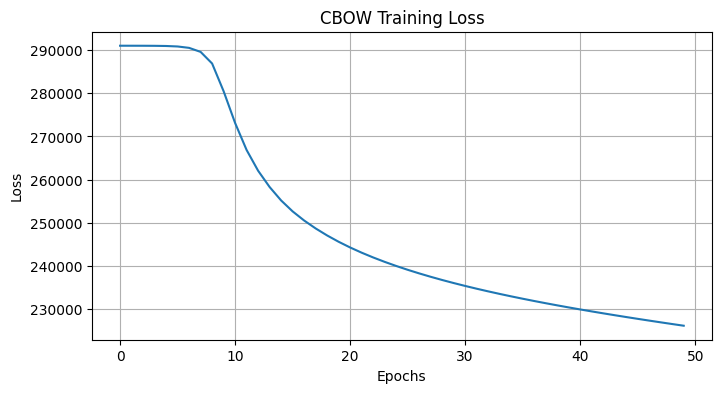

In [90]:
plt.figure(figsize=(8, 4))
plt.plot(loss_history)
plt.title("CBOW Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

In [ ]:
embeddings = model.W1  # shape: (vocab_size, embedding_dim)

def nearest_words(query, word2idx, idx2word, embeddings, top_k=5):
    if query not in word2idx:
        return f"Word '{query}' not in vocabulary."
    
    query_vec = embeddings[word2idx[query]]
    similarities = []
    
    for i, vec in enumerate(embeddings):
        sim = np.dot(query_vec, vec) / (np.linalg.norm(query_vec) * np.linalg.norm(vec) + 1e-9)
        similarities.append((idx2word[i], sim))
    
    similarities = sorted(similarities, key=lambda x: -x[1])
    return similarities[1:top_k+1]

In [98]:
nearest_words("what", word2idx, idx2word, embeddings)

[('this', np.float64(0.9987834635845211)),
 ('slavery', np.float64(0.9984573107679119)),
 ('achilles', np.float64(0.9982988168018463)),
 ('been', np.float64(0.9980500223065806)),
 ('many', np.float64(0.9971957927541856))]

## CBOW with PyTouch

In [37]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import re

In [81]:
with open("text8", "r", encoding="utf-8") as f:
    text = f.read()

text = text[:50000000]

In [82]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r"[^a-zA-Z0-9\s]", "", text)
    words = text.split()
    return words

words = preprocess_text(text)

In [83]:
words

['anarchism',
 'originated',
 'as',
 'a',
 'term',
 'of',
 'abuse',
 'first',
 'used',
 'against',
 'early',
 'working',
 'class',
 'radicals',
 'including',
 'the',
 'diggers',
 'of',
 'the',
 'english',
 'revolution',
 'and',
 'the',
 'sans',
 'culottes',
 'of',
 'the',
 'french',
 'revolution',
 'whilst',
 'the',
 'term',
 'is',
 'still',
 'used',
 'in',
 'a',
 'pejorative',
 'way',
 'to',
 'describe',
 'any',
 'act',
 'that',
 'used',
 'violent',
 'means',
 'to',
 'destroy',
 'the',
 'organization',
 'of',
 'society',
 'it',
 'has',
 'also',
 'been',
 'taken',
 'up',
 'as',
 'a',
 'positive',
 'label',
 'by',
 'self',
 'defined',
 'anarchists',
 'the',
 'word',
 'anarchism',
 'is',
 'derived',
 'from',
 'the',
 'greek',
 'without',
 'archons',
 'ruler',
 'chief',
 'king',
 'anarchism',
 'as',
 'a',
 'political',
 'philosophy',
 'is',
 'the',
 'belief',
 'that',
 'rulers',
 'are',
 'unnecessary',
 'and',
 'should',
 'be',
 'abolished',
 'although',
 'there',
 'are',
 'differing',
 '

In [84]:
from collections import Counter

min_count = 5
word_counts = Counter(words)
vocab = [w for w, c in word_counts.items() if c >= min_count]

word2idx = {w: i for i, w in enumerate(vocab)}
idx2word = {i: w for i, w in enumerate(vocab)}

word_indices = [word2idx[w] for w in words if w in word2idx]

In [85]:
word2idx, idx2word

({'anarchism': 0,
  'originated': 1,
  'as': 2,
  'a': 3,
  'term': 4,
  'of': 5,
  'abuse': 6,
  'first': 7,
  'used': 8,
  'against': 9,
  'early': 10,
  'working': 11,
  'class': 12,
  'radicals': 13,
  'including': 14,
  'the': 15,
  'diggers': 16,
  'english': 17,
  'revolution': 18,
  'and': 19,
  'sans': 20,
  'french': 21,
  'whilst': 22,
  'is': 23,
  'still': 24,
  'in': 25,
  'pejorative': 26,
  'way': 27,
  'to': 28,
  'describe': 29,
  'any': 30,
  'act': 31,
  'that': 32,
  'violent': 33,
  'means': 34,
  'destroy': 35,
  'organization': 36,
  'society': 37,
  'it': 38,
  'has': 39,
  'also': 40,
  'been': 41,
  'taken': 42,
  'up': 43,
  'positive': 44,
  'label': 45,
  'by': 46,
  'self': 47,
  'defined': 48,
  'anarchists': 49,
  'word': 50,
  'derived': 51,
  'from': 52,
  'greek': 53,
  'without': 54,
  'archons': 55,
  'ruler': 56,
  'chief': 57,
  'king': 58,
  'political': 59,
  'philosophy': 60,
  'belief': 61,
  'rulers': 62,
  'are': 63,
  'unnecessary': 64,
  

In [86]:
vocab_size = len(vocab)
print(f"Vocabulary size: {vocab_size}")

Vocabulary size: 48753


Build the dataset

In [87]:
class CBOWDataset(Dataset):
    def __init__(self, data, window_size=2):
        self.data = data
        self.window_size = window_size

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        target = self.data[idx]
        start = max(0, idx - self.window_size)
        end = min(len(self.data), idx + self.window_size + 1)
        context = [self.data[i] for i in range(start, end) if i != idx]

        # Pad context to fixed length
        while len(context) < 2 * self.window_size:
            context.append(0)

        return torch.tensor(context, dtype=torch.long), torch.tensor(target, dtype=torch.long)


In [88]:
window_size = 2
dataset = CBOWDataset(word_indices, window_size)
batch_size = 512
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)

In [89]:
class CBOWModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super(CBOWModel, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear = nn.Linear(embedding_dim, vocab_size)

    def forward(self, context_words):
        # context_words: (batch_size, window*2)
        embeds = self.embeddings(context_words)  # (batch_size, window*2, embedding_dim)
        h = embeds.mean(dim=1)                  # (batch_size, embedding_dim)
        out = self.linear(h)                     # (batch_size, vocab_size)
        return out

In [90]:
embedding_dim = 50
model = CBOWModel(vocab_size, embedding_dim)

In [91]:
# Use GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

CBOWModel(
  (embeddings): Embedding(48753, 50)
  (linear): Linear(in_features=50, out_features=48753, bias=True)
)

In [92]:
print(next(model.parameters()).device)

cuda:0


Training

In [95]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 25
loss_history = []

In [96]:
for epoch in range(epochs):
    total_loss = 0
    for context, target in dataloader:
        context = context.to(device)
        target = target.to(device)

        optimizer.zero_grad()
        output = model(context)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(dataloader)
    loss_history.append(avg_loss)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")

Epoch 1/25, Loss: 6.1829
Epoch 2/25, Loss: 5.9849
Epoch 3/25, Loss: 5.8676
Epoch 4/25, Loss: 5.7864
Epoch 5/25, Loss: 5.7263
Epoch 6/25, Loss: 5.6798
Epoch 7/25, Loss: 5.6424
Epoch 8/25, Loss: 5.6116
Epoch 9/25, Loss: 5.5859
Epoch 10/25, Loss: 5.5639
Epoch 11/25, Loss: 5.5451
Epoch 12/25, Loss: 5.5285
Epoch 13/25, Loss: 5.5138
Epoch 14/25, Loss: 5.5010
Epoch 15/25, Loss: 5.4893
Epoch 16/25, Loss: 5.4786
Epoch 17/25, Loss: 5.4688
Epoch 18/25, Loss: 5.4599
Epoch 19/25, Loss: 5.4517
Epoch 20/25, Loss: 5.4437
Epoch 21/25, Loss: 5.4363
Epoch 22/25, Loss: 5.4291
Epoch 23/25, Loss: 5.4221
Epoch 24/25, Loss: 5.4151
Epoch 25/25, Loss: 5.4083


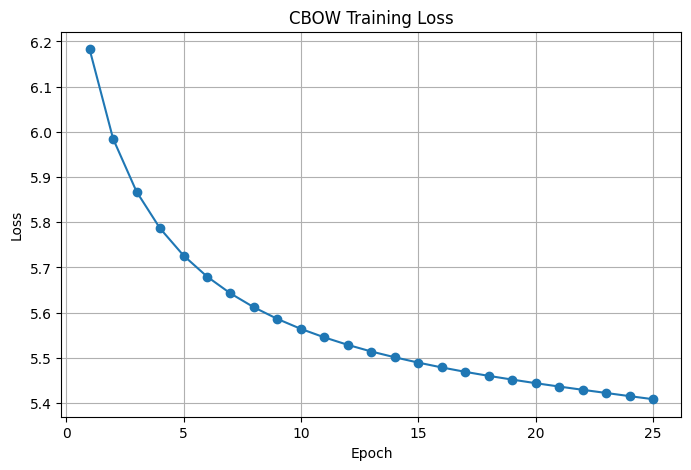

In [97]:
plt.figure(figsize=(8, 5))
plt.plot(range(1, epochs+1), loss_history, marker='o')
plt.title("CBOW Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

In [98]:
embeddings = model.embeddings.weight.data.cpu().numpy()
print("Embeddings shape:", embeddings.shape)

Embeddings shape: (48753, 50)


Testing Model

In [108]:
def nearest_words(query, word2idx, idx2word, embeddings, top_k=5):
    if query not in word2idx:
        return f"Word '{query}' not in vocabulary."
    
    query_vec = embeddings[word2idx[query]]
    similarities = []
    
    for i, vec in enumerate(embeddings):
        sim = np.dot(query_vec, vec) / (np.linalg.norm(query_vec) * np.linalg.norm(vec) + 1e-9)
        similarities.append((idx2word[i], sim))
    
    similarities = sorted(similarities, key=lambda x: -x[1])
    return similarities[1:top_k+1]

In [109]:
nearest_words("king", word2idx, idx2word, embeddings)

[('emperor', np.float32(0.7381723)),
 ('son', np.float32(0.69632524)),
 ('tsar', np.float32(0.6872842)),
 ('prince', np.float32(0.6792712)),
 ('duke', np.float32(0.66636693))]

In [145]:
def plot_nearest_neighbors(words, word2idx, idx2word, embeddings, top_k=5):
    results = {}
    for w in words:
        if w not in word2idx:
            results[w] = None
        else:
            qvec = embeddings[word2idx[w]]
            sims = []
            for i, vec in enumerate(embeddings):
                sim = np.dot(qvec, vec) / (np.linalg.norm(qvec) * np.linalg.norm(vec) + 1e-9)
                sims.append((idx2word[i], sim))

            sims = sorted(sims, key=lambda x: -x[1])
            results[w] = sims[1:top_k+1]

    pca = PCA(n_components=2)
    reduced = pca.fit_transform(embeddings)

    n_words = len(words)
    cols = min(4, n_words)
    rows = (n_words + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(cols*4, rows*4))
    axes = np.array(axes).reshape(rows, cols)

    idx = 0
    for r in range(rows):
        for c in range(cols):
            ax = axes[r, c]
            if idx >= n_words:
                ax.axis("off")  # hide empty boxes
                continue

            w = words[idx]
            ax.set_title(f"Nearest: {w}", fontsize=10)

            if results[w] is None:
                ax.text(0.5, 0.5, "Not in vocab", ha="center")
                ax.set_xticks([])
                ax.set_yticks([])
                idx += 1
                continue

            # Plot query word
            qx, qy = reduced[word2idx[w]]
            ax.scatter(qx, qy, s=50, label=w)

            # Plot neighbors
            for nb, _ in results[w]:
                ix = word2idx[nb]
                nx, ny = reduced[ix]
                ax.scatter(nx, ny, s=30)
                ax.text(nx, ny, nb, fontsize=7)

            ax.set_xticks([])
            ax.set_yticks([])
            idx += 1

    plt.tight_layout()
    plt.show()

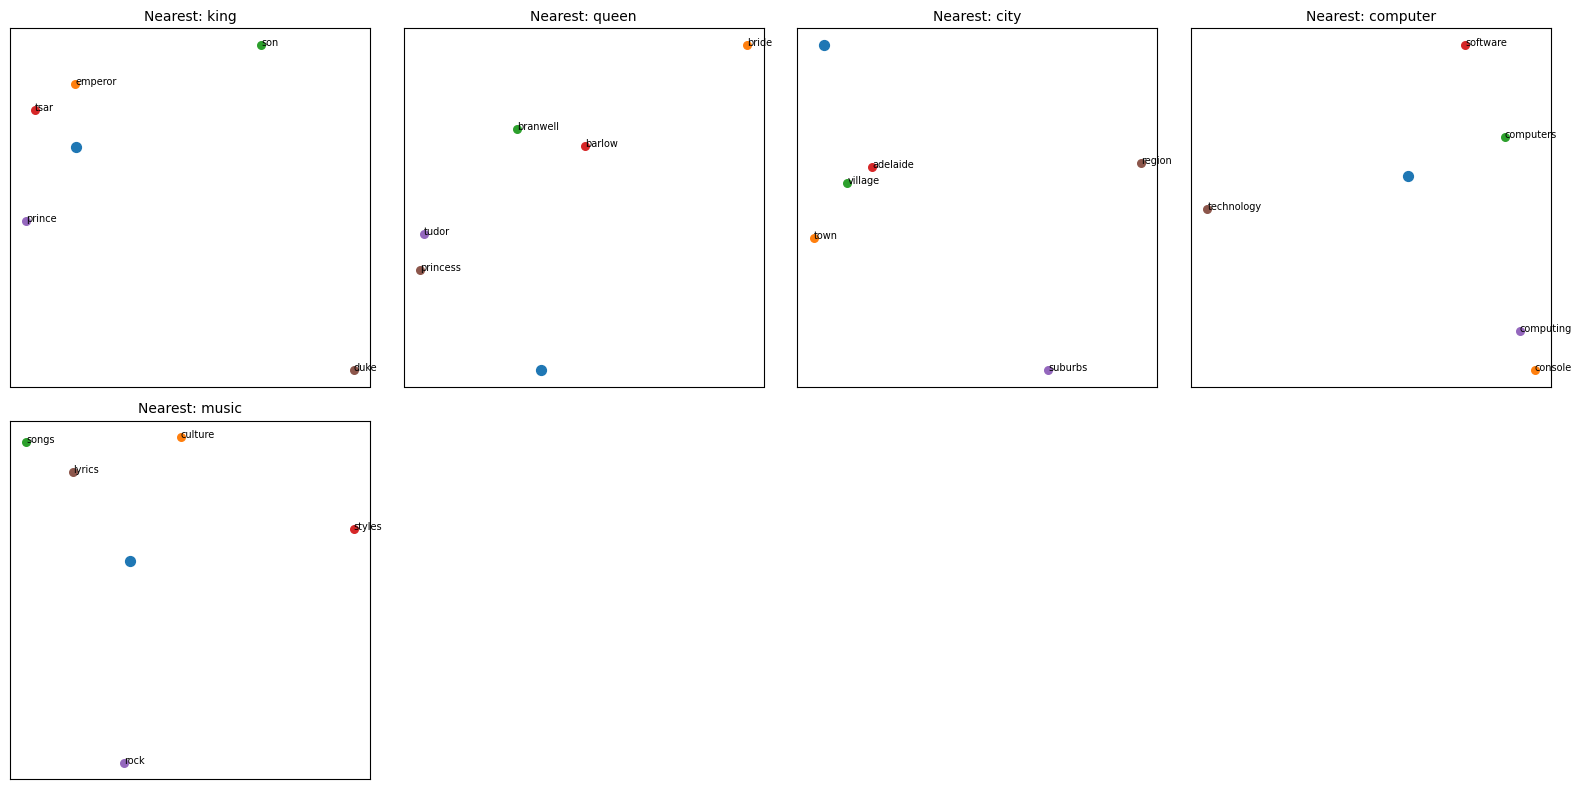

In [146]:
test_words = ["king", "queen", "city", "computer", "music"]
plot_nearest_neighbors(test_words, word2idx, idx2word, embeddings)

### Save and Load Model 

- Saving Model

```python
import json

with open("vocab.json", "w", encoding="utf-8") as f:
    json.dump({"word2idx": word2idx, "idx2word": idx2word}, f)

torch.save(model.state_dict(), "cbow_model.pth")
print("Model saved successfully!")

```
- Load Model

```python
with open("vocab.json", "r", encoding="utf-8") as f:
    vocab_data = json.load(f)
word2idx = vocab_data["word2idx"]
idx2word = vocab_data["idx2word"]
```
```python
model_loaded = CBOWModel(vocab_size=len(vocab), embedding_dim=embedding_dim)
model_loaded.load_state_dict(torch.load("cbow_model.pth"))
model_loaded.to(device)
model_loaded.eval()
print("Model loaded successfully!")

```